### Clouds : test clouds 3D with NEXT MC events

G. Díaz, J. A Hernando


May 2021

In [1]:
#%matplotlib inline 

%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

plt.rcParams['image.cmap'] = 'rainbow'

In [97]:
import hipy.utils        as ut
import hipy.pltext       as pltext
#import hipy.hfit         as hfit

import clouds.clouds    as clouds
import clouds.graphs    as graphs
import clouds.pltclouds as pltclouds

#import bes.bes           as bes
#import bes.clouds        as clouds
#import next.reco.chits      as chits
#import next.reco.display    as nplay


In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Mon May 10 12:26:06 2021


In [5]:
#import os
import re
import glob
#import numpy  as np
#import pandas as pd
#import tables as tb

#import matplotlib
#from matplotlib import cm
#from matplotlib import pyplot as plt

#import clouds
#import pltclouds

In [6]:
get_file_number = lambda filename: int(re.findall("_[0-9]+_", filename)[0][1:-1])

def split_hits(hitsdf, weight="E"):
    
    xyz = hitsdf[["X", "Y", "Z"]].values
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    w = hitsdf[weight].values
    
    return x, y, z, w

# ojo
#fname = '/home/hernando/data/NEW/MC/bb0nu_esmeralda/map_8264.h5'
fname = '/Users/hernando/investigacion/NEXT/data/MC/NEW/bb0nu_esmeralda/map_8264.h5'
maps_te = pd.read_hdf(fname, "time_evolution")
dv = maps_te.dv.mean()

In [7]:
#datadir   = "/home/hernando/data/NEW/MC/bb0nu_esmeralda/"
datadir   = "/Users/hernando/investigacion/NEXT/data/MC/NEW/bb0nu_esmeralda/"
files     = glob.glob(datadir + '*.h5')
def file_number(file):
    fname = file .split('/')[-1]
    ifile = fname.split('_')[1]
    return str(ifile)
#print(files)
filenames = sorted(files, key = file_number)
print('total files', len(filenames))

total files 501


In [8]:
#filename = np.random.choice(filenames)
#print(filename)
#filename = '/home/hernando/data/NEW/MC/bb0nu_esmeralda/esmeralda_321_0nubb.h5'
#print("File number", get_file_number(filename))

In [9]:
# events good:  3214
# File number 125 , Event 1252
# filename, event  =  360 ,  3604
# filename, event  =  379 ,  3798

# interesing problematic events
# filename, event  =  190 ,  1902


In [201]:
israndom = True
filename = np.random.choice(filenames) if israndom else filename

CHITS_lowTh  = pd.read_hdf(filename, "/CHITS/lowTh") .groupby("event")
CHITS_highTh = pd.read_hdf(filename, "/CHITS/highTh").groupby("event")

MChits = pd.read_hdf(filename, "MC/hits").groupby("event_id")
data_events = pd.read_hdf(filename, "Run/events")
event       = np.random.choice(data_events["evt_number"]) if israndom else event
print('filename, event  = ', get_file_number(filename), ', ', event)

filename, event  =  73 ,  738


In [202]:
low  = CHITS_lowTh .get_group(event)
high = CHITS_highTh.get_group(event)
true = MChits      .get_group(event)

x, y, z, w = split_hits(low, weight="E")
coors = (x, y, z)
ene   = 1e-5 * w
steps = (10., 10., 2.)

xmc, ymc, zmc = true["x"].values, true["y"].values, dv*true["z"].values
enemc, timemc = true["energy"].values, true['time'].values
coorsmc = (xmc, ymc, zmc)

print('Energy MC ', np.sum(enemc), ', RC ', np.sum(ene))

Energy MC  2.4578302 , RC  2.1316829623937608


## Draw MC event

<IPython.core.display.Javascript object>


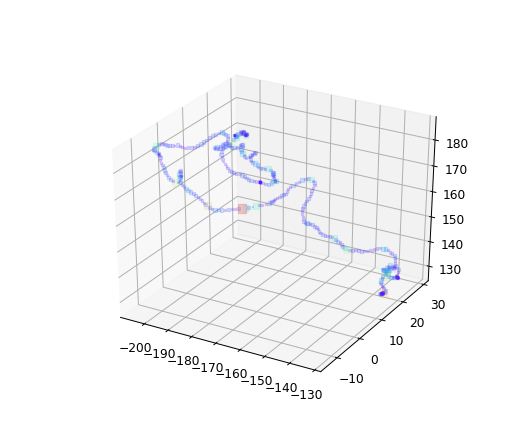

In [203]:
subplot = pltext.canvas(1, 1)
plt.gcf().add_subplot(1, 1 ,1, projection = '3d')
scalemc = enemc/np.max(enemc)
plt.gca().scatter(xmc, ymc, zmc, c = scalemc , s = 50 * scalemc, marker = 's', alpha = 0.2);

<IPython.core.display.Javascript object>


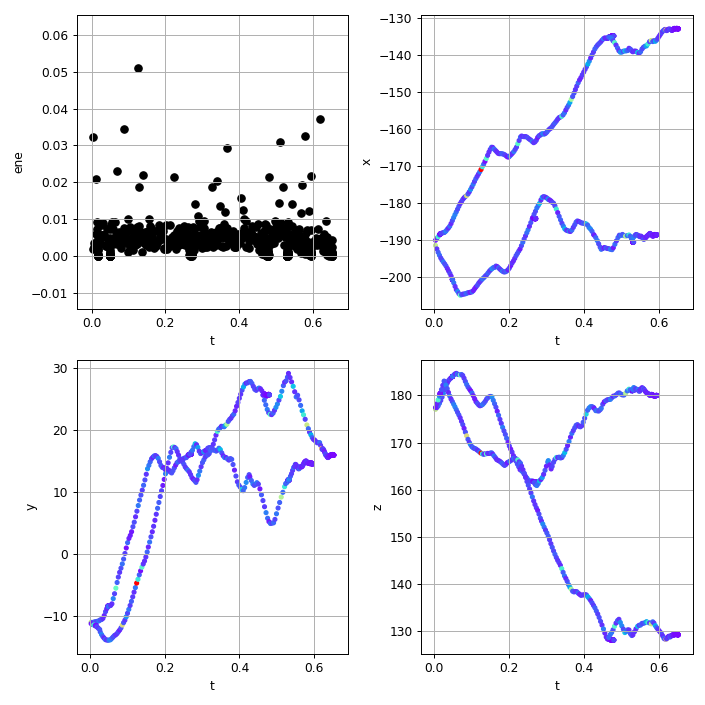

In [204]:
pltclouds.plot_tview(coorsmc, enemc, timemc)

## Draw Reco

<IPython.core.display.Javascript object>


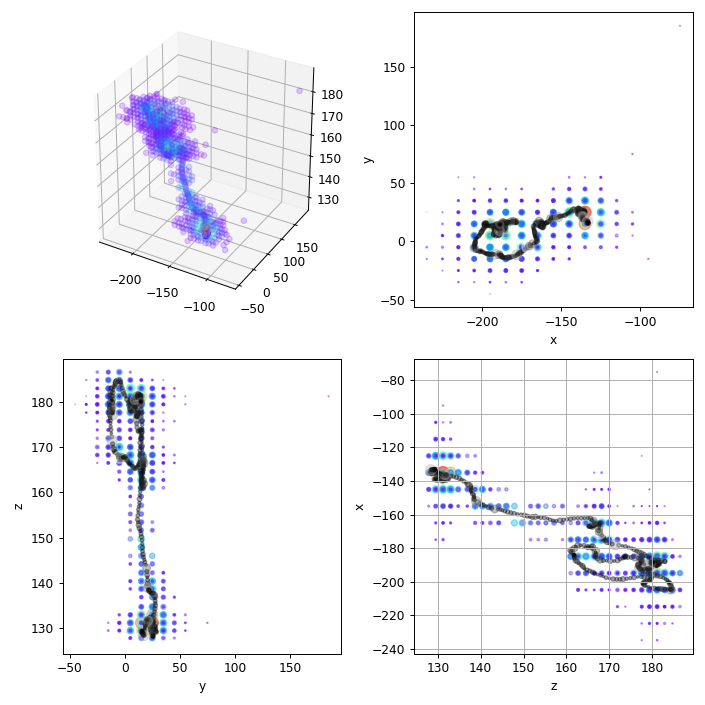

In [205]:
pltclouds.plot_xyview(coors, ene, coorsmc, enemc)

## Clouds 

In [206]:
cut   = -0.1
steps = (10., 10., 4.)
bins, mask, cells, df = clouds.clouds(coors, steps, ene, cut)
cenemc = clouds.cells_value(bins, mask, coorsmc, enemc)
df['mcene']  = cenemc
df['istrue'] = cenemc > 0

<IPython.core.display.Javascript object>


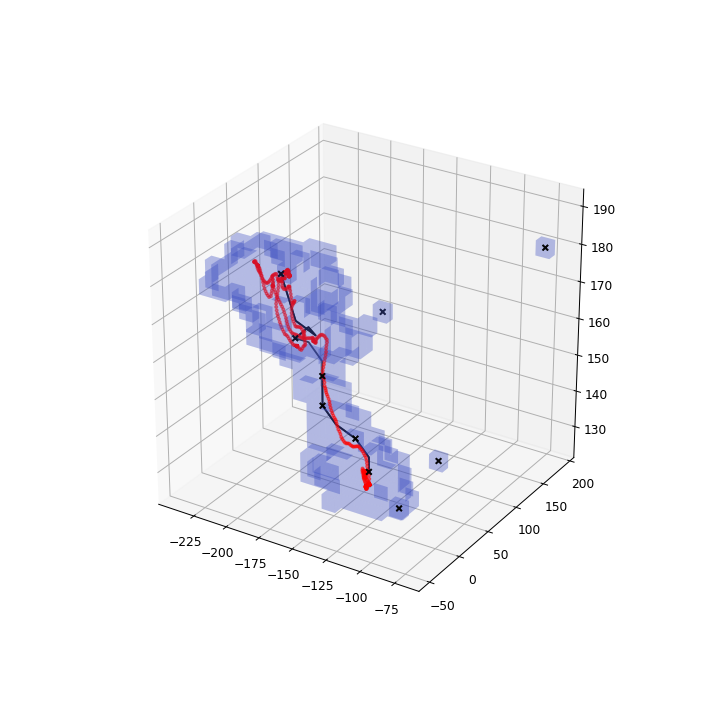

In [207]:
plt.figure(figsize = (8, 8));
#draw = pltclouds.drawer(cells, bins, df)
draw = pltclouds.draw_cloud(cells, bins, df, 'e')
plt.gca().scatter(xmc, ymc, zmc, c = 'red' , marker = '.', alpha = 0.5);
#pltclouds.rotate()
opts = {'ispass': {'marker':'d', 'c':'black'}}
draw(iscore = True, ridge = False, cloud = False, link = False, ispass = False, rotate = False, opts = opts)
#pltclouds.rotate();

<IPython.core.display.Javascript object>


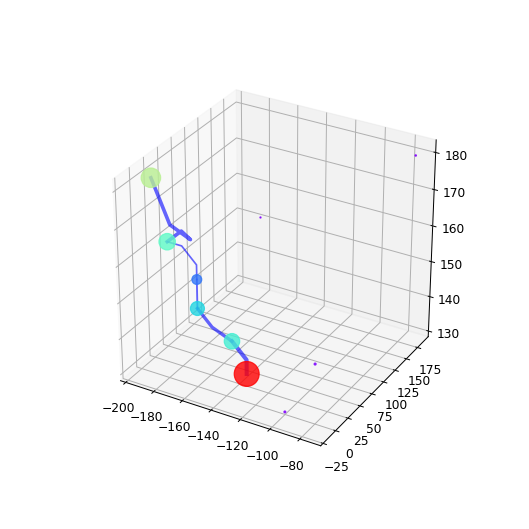

[(142, 180), (248, 247), (246, 247), (245, 292), (345, 368)]


<IPython.core.display.Javascript object>


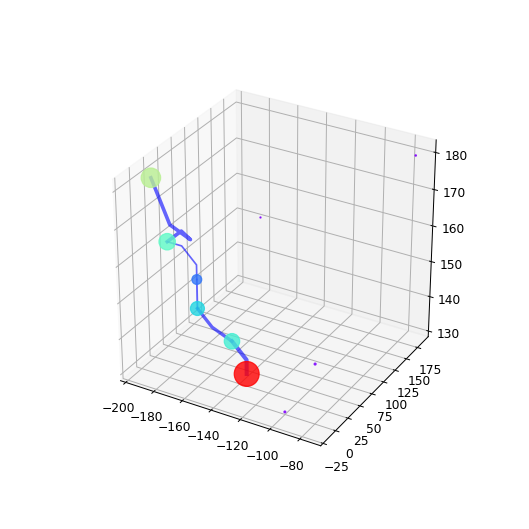

[(142, 180), (248, 247), (368, 345), (292, 245), (246, 247)]


<IPython.core.display.Javascript object>


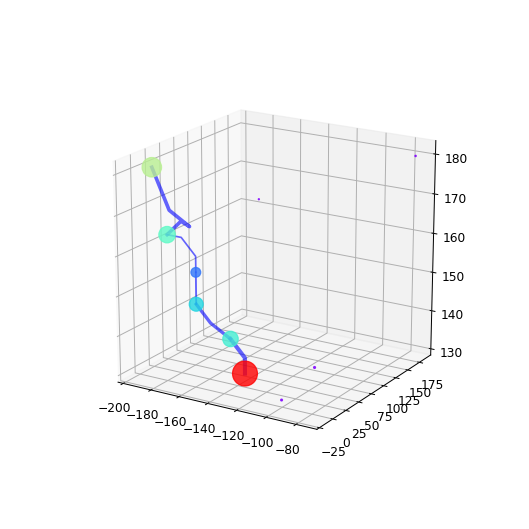

[(142, 180), (248, 247), (368, 345), (292, 245), (246, 247)]


In [208]:
cenes = df.evalue.values
cnode = df.enode .values
graph0 = graphs._graph_simple(bins, mask, cells, cenes, cnode)
graph1 = graphs._graph_new   (bins, mask, cells, cenes, cnode)
graph2 = graphs._graph       (bins, mask, cells, cenes, cnode)
plt.figure(figsize = (6, 6))
pltclouds.draw_graph(cells, df.evalue, df.epath, graph0.nlink)
plt.figure(figsize = (6, 6))
pltclouds.draw_graph(cells, df.evalue, df.epath, graph1.nlink)
plt.figure(figsize = (6, 6))
pltclouds.draw_graph(cells, df.evalue, df.epath, graph2.nlink)

is border  184
id border  9 175
 num multi-border cells  9 415
 nodes with multiborder  [157 265]
 border cells of node  0 138  :  65
 border cells of node  1 261 :  25
 are multi-border?  0
 border cells of node  2 65 :  15
 are multi-border?  0
 border cells of node  3 157 :  38
 are multi-border?  5
is border  73
id border  0 73
 num of multi border cells  73
 border cells of node  4 265 :  26
 are multi-border?  4
is border  0
id border  0 0
 num of multi border cells  0
 border cells of node  5 188 :  14
 are multi-border?  0
 border cells of node  6 407 :  0
 border cells of node  7 115 :  1
 are multi-border?  0
 border cells of node  1 261  :  25
 border cells of node  2 65 :  15
 are multi-border?  0
 border cells of node  3 157 :  38
 are multi-border?  5
is border  23
id border  0 23
 num of multi border cells  23
 border cells of node  4 265 :  26
 are multi-border?  4
is border  25
id border  0 25
 num of multi border cells  25
 border cells of node  5 188 :  14
 are multi

<IPython.core.display.Javascript object>


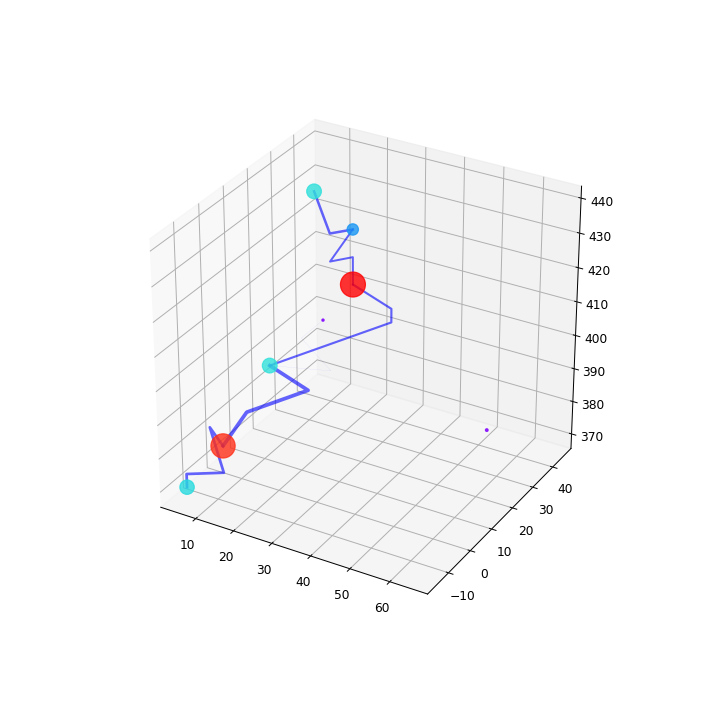

[(77, 136), (233, 157), (327, 245), (263, 251), (110, 115), (265, 253)]


In [164]:
cenes = df.evalue.values
cnode = df.enode .values
graph = graphs._graph_new(bins, mask, cells, cenes, cnode)
plt.figure(figsize = (8, 8))
pltclouds.draw_graph(cells, df.evalue, df.epath, graph.nlink)

is border  184
id border  9 175
is border  0
id border  0 0
is border  40
id border  0 40
is border  73
id border  0 73
is border  0
id border  0 0
is border  0
id border  0 0
is border  0
id border  0 0
is border  0
id border  0 0
is border  0
id border  0 0
is border  23
id border  0 23
is border  25
id border  0 25
is border  0
id border  0 0
is border  0
id border  0 0
is border  0
id border  0 0
is border  0
id border  0 0
is border  0
id border  0 0
is border  0
id border  0 0
is border  0
id border  0 0
is border  0
id border  0 0
is border  0
id border  0 0
is border  0
id border  0 0
is border  0
id border  0 0
is border  2
id border  0 2
is border  30
id border  0 30
is border  0
id border  0 0
is border  0
id border  0 0
is border  0
id border  0 0
is border  0
id border  0 0
is border  0
id border  0 0


<IPython.core.display.Javascript object>


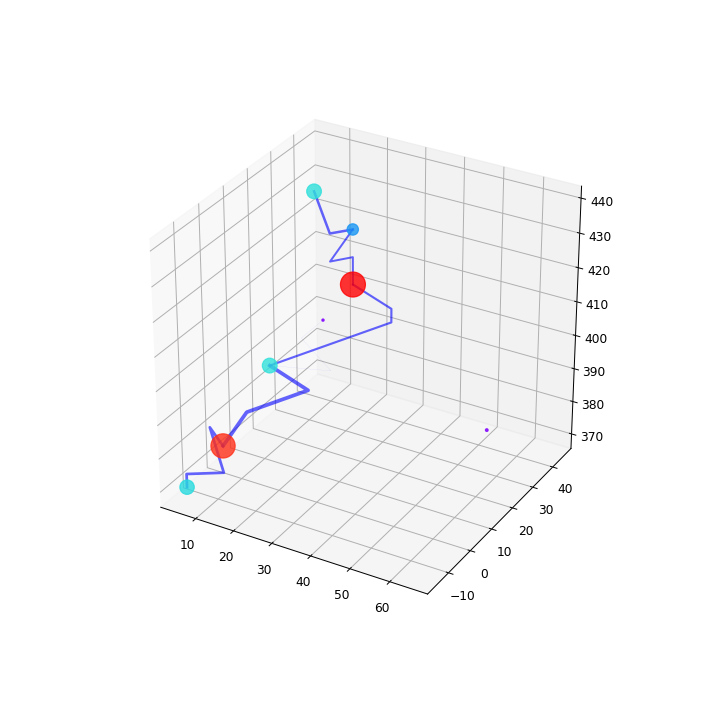

[(77, 136), (233, 157), (327, 245), (263, 251), (110, 115), (265, 253)]


In [165]:
cenes = df.evalue.values
cnode = df.enode .values
graph = graphs._graph(bins, mask, cells, cenes, cnode)
plt.figure(figsize = (8, 8))
pltclouds.draw_graph(cells, df.evalue, df.epath, graph.nlink)

In [134]:
cenes = df.evalue.values
cnode = df.enode .values

graph = graphs._graph_new(bins, mask, cells, cenes, cnode)

nodes   [180 316  48 128 297 335 371]
enodes  [3.16783477e+01 1.15481948e+01 6.31524439e+00 4.86008618e+00
 1.35182911e-02 4.86487903e-03 3.27540237e-03]
is border  170
id border  26 144
 num border cells  170
 num multi-border cells  26 372
 border cells of node  0 180  :  98
 border cells of node  1 316 :  17
 num of single border cells  38
 are multi-border?  0
 link nodes  180 316 , n cells  38
 link ids    275 274 , enes  0.49381182572412424 0.38047337609156723
 border cells of node  2 48 :  22
 num of single border cells  32
 are multi-border?  0
 link nodes  180 48 , n cells  32
 link ids    35 41 , enes  0.2035200909799161 0.25787616973209493
 border cells of node  3 128 :  32
 num of single border cells  72
 are multi-border?  0
 link nodes  180 128 , n cells  72
 link ids    172 128 , enes  0.474069824063938 0.5032802034362114
 border cells of node  4 297 :  1
 num of single border cells  2
 are multi-border?  0
 link nodes  180 297 , n cells  2
 link ids    296 297 , enes  0

In [136]:
print(graph.nlink)

[[ -1 275  35 172 296  -1  -1]
 [274  -1  -1  -1  -1  -1  -1]
 [ 41  -1  -1  -1  -1  -1  -1]
 [128  -1  -1  -1  -1  -1  -1]
 [297  -1  -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1  -1]]


In [137]:
cenes = df.evalue.values
cnode = df.enode .values

graph = graphs._graph_simple(bins, mask, cells, cenes, cnode)

is border  170
id border  26 144


In [138]:
graph.nlink

array([[ -1,  -1, 111,  -1,  -1,  -1,  -1],
       [ -1,  -1, 128,  -1,  -1,  -1,  -1],
       [145, 172,  -1, 296, 275,  -1,  -1],
       [ -1,  -1, 297,  -1,  -1,  -1,  -1],
       [ -1,  -1, 274,  -1,  -1,  -1,  -1],
       [ -1,  -1,  -1,  -1,  -1,  -1,  -1],
       [ -1,  -1,  -1,  -1,  -1,  -1,  -1]])

<IPython.core.display.Javascript object>


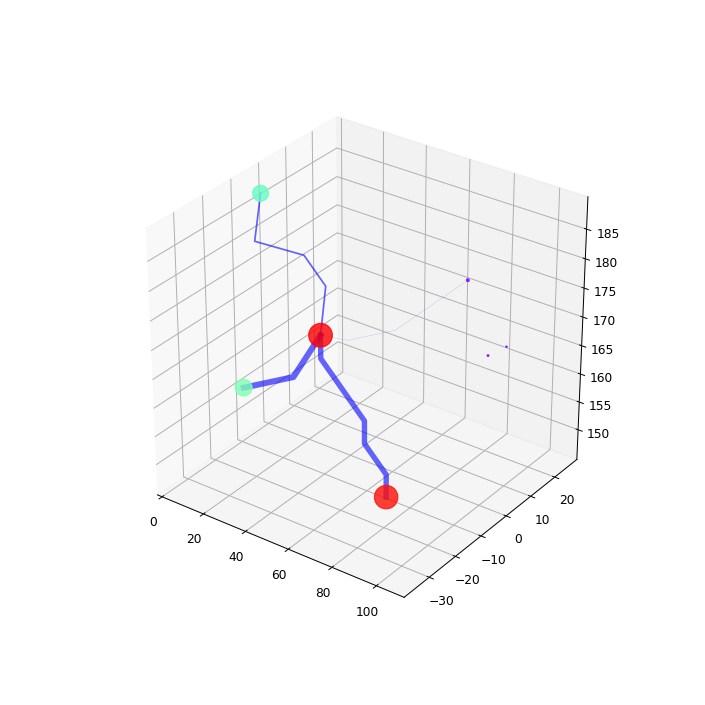

[(111, 145), (128, 172), (296, 297), (275, 274)]


In [140]:
plt.figure(figsize = (8, 8))
pltclouds.draw_graph(cells, df.evalue, df.epath, graph.nlink)

<IPython.core.display.Javascript object>


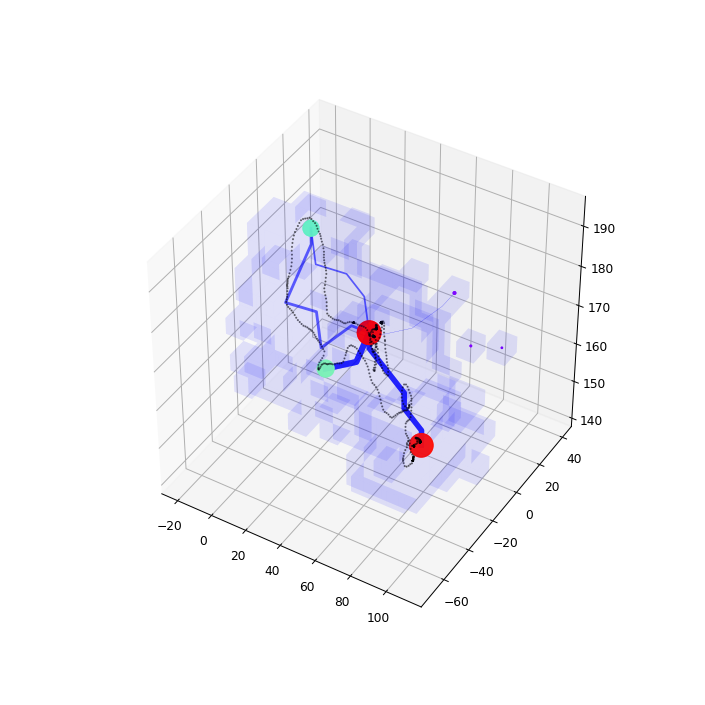

[(275, 274), (35, 41), (172, 128), (296, 297)]


In [135]:
plt.figure(figsize = (8, 8))
pltclouds.draw_voxels(bins, mask, cells, alpha = 0.05)
pltclouds.draw_graph(cells, df.evalue, df.epath, graph.nlink)
plt.gca().scatter(xmc, ymc, zmc, c = 'black' , marker = '.', s = 2, alpha = 0.5);

In [105]:
#df

In [130]:
xana = clouds.analysis(df)
print(xana)

{'eeisnodesuccess': 4, 'eeisnodefailures': 3, 'eeisnodeeff': 0.5714285714285714, 'eeisbordersuccess': 32, 'eeisborderfailures': 138, 'eeisbordereff': 0.18823529411764706, 'eeispasssuccess': 3, 'eeispassfailures': 5, 'eeispasseff': 0.375, 'eeisridgesuccess': 8, 'eeisridgefailures': 9, 'eeisridgeeff': 0.47058823529411764, 'eiscoresuccess': 0, 'eiscorefailures': 0, 'eiscoreeff': -1}


In [465]:
def plot_analysis(df, name = 'e'):
    
    ene  = df.evalue.values
    lap  = df.pvalue.values
    
    true = df.istrue.values
    cells_types = (name + 'isnode', name +'isborder',
                   name + 'ispass', name +'isridge', 'iscore')
    
    subplot = pltext.canvas(2 * len(cells_types), 2, 4, 4)
    
    dat = {}
    for i, itype in enumerate(cells_types):
        vals  = df[itype].values  
        ntot  = np.sum(vals)
        yes   = vals & true
        noes  = vals & (~true)
        nyes  = np.sum(yes)
        nnoes = np.sum(noes)
        eff   = float(nyes/ntot) if ntot >0 else -1
        dat[name+itype+'success']  = nyes
        dat[name+itype+'failures'] = nnoes
        dat[name+itype+'eff']      = eff
        subplot(2 * i + 1)
        pltext.hist(ene[yes ], 50)
        pltext.hist(ene[noes], 50)
        plt.xlabel('ene')
        plt.title(itype)
        subplot(2 * i + 2)
        pltext.hist(lap[yes ], 50)
        pltext.hist(lap[noes], 50)
        plt.xlabel('lap')
        plt.title(itype)
        
    plt.tight_layout()
    

<IPython.core.display.Javascript object>


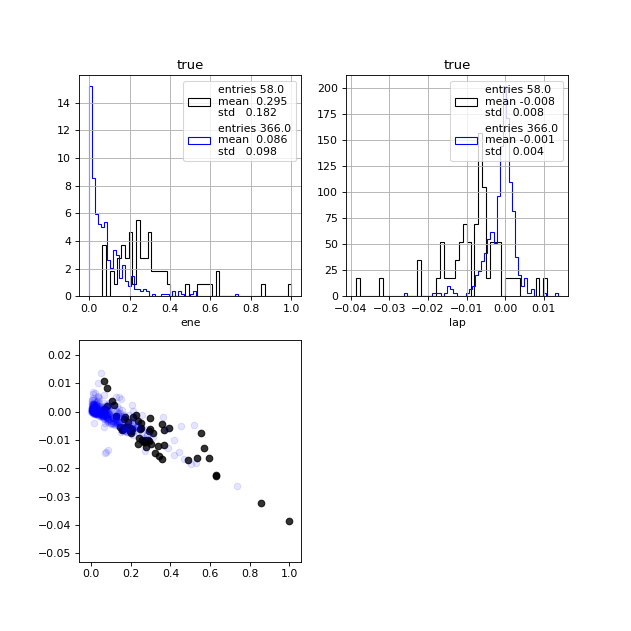

In [466]:
xene   = df.evalue.values
lap    = df.pvalue.values
istrue = df.istrue.values
subplot = pltext.canvas(4, 2, 4, 4)
subplot(1)
pltext.hist(xene[istrue] , 50, density = True)
pltext.hist(xene[~istrue], 50, density = True)
plt.xlabel('ene'); plt.title('true')
subplot(2)
pltext.hist(lap[istrue] , 50, density = True)
pltext.hist(lap[~istrue], 50, density = True)
plt.xlabel('lap'); plt.title('true')
subplot(3)
plt.scatter(xene[istrue] , lap[istrue] , alpha =.8)
plt.scatter(xene[~istrue], lap[~istrue], alpha =.1)

<IPython.core.display.Javascript object>


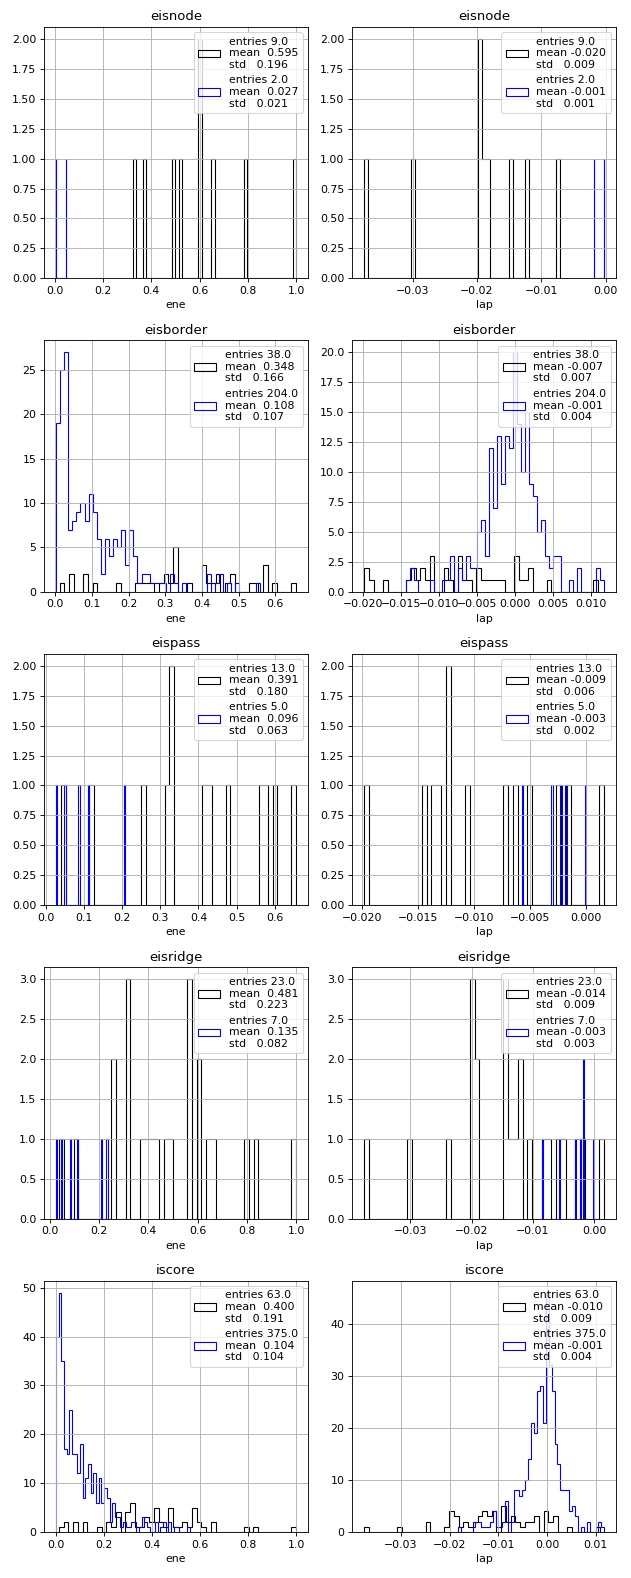

In [412]:
plot_analysis(df)

<IPython.core.display.Javascript object>


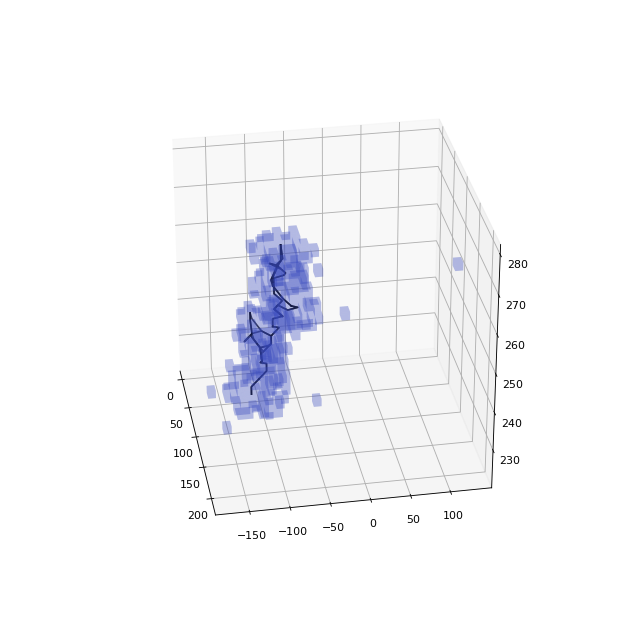

isnode {'marker': 'x', 'c': 'black', 'alpha': 0.8}
iscore {'alpha': 0.2}
ridge {'c': 'black', 'alpha': 0.8}


In [226]:
plt.figure(figsize = (8, 8))
draw(value = False, iscore = True, opts={'iscore':{'alpha':0.2}}, rotate = True)

<IPython.core.display.Javascript object>


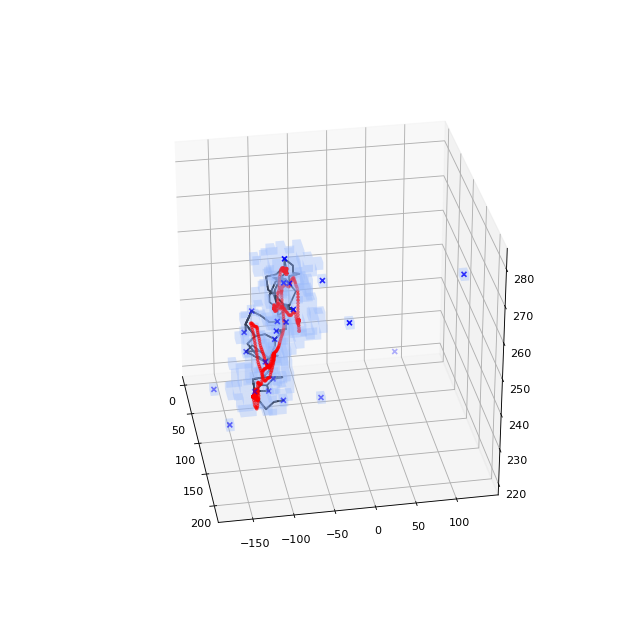

In [197]:
plt.figure(figsize = (8, 8));
#draw = pltclouds.drawer(cells, bins, df)
draw = pltclouds.drawer(cells, bins, df, 'p', plot = False)
plt.gca().scatter(xmc, ymc, zmc, c = 'red' , marker = '.', alpha = 0.5);
draw();
pltclouds.rotate()

<IPython.core.display.Javascript object>


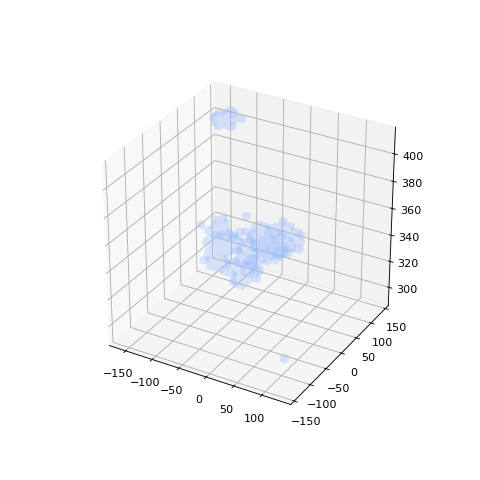

In [180]:
plt.figure(figsize = (6, 6));
draw(value = True, ispass = True, ridge = False)

In [105]:
np.sum(df.eispass)

20

In [31]:
draw(value = True)

In [ ]:
cells_select = pltclouds.cells_select

plt.figure(figsize = (10, 10))
plt.gca(projection = '3d')
evalue = df.pvalue.values
scale  = evalue

xx, yy, zz = np.meshgrid(*bins)
umask      = np.copy(mask)
filled     = np.swapaxes(umask, 0, 1).astype(bool)

norm      = colors  .Normalize(vmin=min(scale), vmax=max(scale), clip=True)
mapper    = colormap.ScalarMappable(norm=norm, cmap=colormap.coolwarm)
facecolor = mapper.to_rgba(scale)
#ax.voxels(x, y, z, filled, alpha=0.5)

plt.gca().voxels(xx, yy, zz, filled, alpha = 0.1, facecolor = facecolor);
plt.gca().scatter(*coorsmc, marker ='.', alpha = 0.2);
#plt.gca().scatter(*cells_select(cells, df.isdisper), marker = 's', alpha = 0.2);
plt.gca().scatter(*cells_select(cells, df.eisnode), marker = 'x', s = 50, alpha = 0.5);

eispass  = df.eispass.values
epath    = df.epath  .values
elink    = df.elink  .values

paths    = clouds.get_new_ridges(eispass, epath, elink)
for path in paths:
    pltclouds.draw_path(cells, path, c = 'black')

In [ ]:
cut = 0
_ana((x, z), (10.,  4.), ene, (xmc, zmc), enemc, ('x', 'z'), cut)
_ana((y, z), (10.,  4.), ene, (ymc, zmc), enemc, ('y', 'z'), cut)
_ana((x, y), (10., 10.), ene, (xmc, ymc), enemc, ('x', 'y'), cut)